In [42]:
import os
import re
import sys
import pandas as pd
import requests
import json
import time
from PIL import Image
from matplotlib import pyplot
from tqdm.auto import tqdm

In [43]:
SAVE_DIR = './data/get-image-rank-sigma-scores-by-model-id/'

DATASET = 'environmental'

In [44]:
os.makedirs(SAVE_DIR, exist_ok=True)

# get models

In [45]:
url = 'http://123.176.98.90:8764/models/rank-embedding/list-models'

In [46]:
data = requests.get(f'{url}?dataset={DATASET}')

In [47]:
model_list = eval(data.content)

In [48]:
model_list = pd.DataFrame(model_list)
model_list.set_index('model_file_hash', inplace=True)

In [49]:
model_list['model_type'].unique(), model_list['input_type'].unique()

(array(['xgboost-rank-pairwise', 'image-pair-ranking-linear',
        'image-pair-ranking-elm-v1'], dtype=object),
 array(['embedding-positive', 'embedding-negative', 'embedding', 'clip'],
       dtype=object))

In [50]:
model_file_hashs = model_list.query('model_type == "image-pair-ranking-elm-v1" and input_type == "clip"').index
# model_file_hashs = model_list.query('model_type == "image-pair-ranking-elm-v1"')['model_file_hash']

# get model ids

In [51]:
url = 'http://123.176.98.90:8764/models/get-id'

In [54]:
model_ids = dict()

for model_hash in tqdm(model_file_hashs, leave=False):
    
    data = requests.get(f'{url}?model_hash={model_hash}')
    
    result = eval(data.content)
    
    if type(result) != int:
        continue
    
    model_ids[result] = model_hash

  0%|          | 0/25 [00:00<?, ?it/s]

# get sigma-scores

In [55]:
url = 'http://123.176.98.90:8764/sigma-score/get-image-rank-sigma-scores-by-model-id'

In [56]:
for model_id in tqdm(model_ids.keys(), leave=False):
    
    output_path = os.path.join(SAVE_DIR, f'{model_id}.json')
    
    if os.path.exists(output_path):
        continue
    
    data = requests.get(f'{url}?model_id={model_id}')
    
    result = eval(data.content)
    
    json.dump(result, open(output_path, 'wt'))

  0%|          | 0/24 [00:00<?, ?it/s]

# get dataset

In [64]:
results = list()

for model_id in tqdm(model_ids, leave=False):
    
    output_path = os.path.join(SAVE_DIR, f'{model_id}.json')
    
    result = json.load(open(output_path))
    
    if len(result) == 0:
        continue
    
    result = pd.DataFrame(result)
    result.drop_duplicates('image_hash', keep='first', inplace=True)
    result.set_index('image_hash', inplace=True)
    break
    result = result[['sigma_score']]
    result.columns = [model_id]
    
    results.append(result)

  0%|          | 0/24 [00:00<?, ?it/s]

In [66]:
model_list

,model_name,model_architecture,model_creation_date,model_type,model_path,input_type,output_type,number_of_training_points,number_of_validation_points,training_loss,validation_loss,graph_report
model_file_hash,,,,,,,,,,,,
f1c86c5cab97986c0ff7733416877354b10132a2ddd7f9279cf6699abc90652f,2023-11-22-00-score-xgboost-rank-pairwise-embe...,ranking,2023-11-22,xgboost-rank-pairwise,environmental/models/ranking/2023-11-22-00-sco...,embedding-positive,score,92560,10284,0.1677506482281763,0.22714896927265654,environmental/models/ranking/2023-11-22-00-sco...
18d29a4f02a507f131f0634ea5970c5a0cb2e5878245111ac27ac647abb68517,2023-11-22-00-score-xgboost-rank-pairwise-embe...,ranking,2023-11-22,xgboost-rank-pairwise,environmental/models/ranking/2023-11-22-00-sco...,embedding-negative,score,92560,10284,0.1506914433880726,0.22851030727343447,environmental/models/ranking/2023-11-22-00-sco...
7cbc65671575b247c9a744afb44a93b421e868531474ad9d66d7a759d33e1214,2023-11-22-00-score-xgboost-rank-pairwise-embe...,ranking,2023-11-22,xgboost-rank-pairwise,environmental/models/ranking/2023-11-22-00-sco...,embedding,score,92560,10284,0.16517934312878133,0.22559315441462466,environmental/models/ranking/2023-11-22-00-sco...
53feacf561e823220928974ccd8cabce1464c128c939b481c583142e1fef32b1,2023-11-22-00-score-xgboost-rank-pairwise-clip,ranking,2023-11-22,xgboost-rank-pairwise,environmental/models/ranking/2023-11-22-00-sco...,clip,score,92560,10284,0.16957649092480553,0.2101322442629327,environmental/models/ranking/2023-11-22-00-sco...
43646cda7fd53fe2b0574ed0a6f2cb4c7f78a955241efffd7dabcf46f5f1fece,2023-11-22-00-score-linear-embedding-positive,ranking,2023-11-21,image-pair-ranking-linear,environmental/models/ranking/2023-11-22-00-sco...,embedding-positive,score,92560,10284,0.2040156126022339,0.20622730255126953,environmental/models/ranking/2023-11-22-00-sco...
...,...,...,...,...,...,...,...,...,...,...,...,...
f12dbb4094ea326282d973c3cbc0387b53095ab4049a4025abfccd1ae65a8192,2023-10-31-00-score-elm-v1-embedding-positive,ranking,2023-10-30,image-pair-ranking-elm-v1,environmental/models/ranking/2023-10-31-00-sco...,embedding-positive,score,26686,2964,0.240755,0.229606,environmental/models/ranking/2023-10-31-00-sco...
4dc18c757547710e60cb64c8c8afee6159983210aef624f71cb1d555877e27f5,2023-10-31-00-score-elm-v1-embedding-negative,ranking,2023-10-30,image-pair-ranking-elm-v1,environmental/models/ranking/2023-10-31-00-sco...,embedding-negative,score,26686,2964,0.396529,0.436148,environmental/models/ranking/2023-10-31-00-sco...
3e1abe0f88ed286445084a140488a953037bf67cf9661552f4ee7e14a28dc511,2023-10-31-00-score-elm-v1-embedding,ranking,2023-10-30,image-pair-ranking-elm-v1,environmental/models/ranking/2023-10-31-00-sco...,embedding,score,26686,2964,0.227758,0.23249,environmental/models/ranking/2023-10-31-00-sco...


In [58]:
results = pd.concat(results, axis=1, join='inner')
selected_ids = results.columns

In [59]:
values = results[selected_ids].values.copy()

In [60]:
values = (values - values.mean(axis=0, keepdims=True)) / values.std(axis=0, keepdims=True)

In [61]:
results['mean'] = values.mean(axis=-1)
results['std'] = values.std(axis=-1)

In [62]:
selected_hashs = list(map(model_ids.get, selected_ids))

Text(0, 0.5, 'std of sigma-scores')

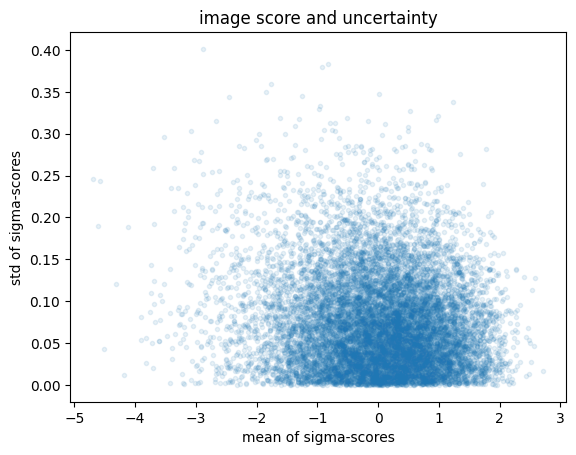

In [63]:
pyplot.plot(results['mean'], results['std'], '.', alpha=0.1)
pyplot.title('image score and uncertainty')
pyplot.xlabel('mean of sigma-scores')
pyplot.ylabel('std of sigma-scores')

In [29]:
from minio import Minio
import requests
import msgpack

In [30]:
def connect_to_minio(minio_addr, access_key, secret_key):
    # Initialize the MinIO client
    client = Minio(minio_addr, access_key, secret_key, secure=False)

    #Check server status
    try:
        response = requests.get("http://" + minio_addr + "/minio/health/live", timeout=5)
        if response.status_code == 200:
            print("Connected to MinIO server.")
        else:
            return None
    except requests.RequestException as e:
        return None
    
    return client

In [31]:
MINIO_ADDRESS = "123.176.98.90:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"

In [32]:
client = connect_to_minio(MINIO_ADDRESS, access_key, secret_key)

Connected to MinIO server.


In [33]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))
from training_worker.ab_ranking.model.ab_ranking_elm_v1 import ABRankingELMBaseModel

In [35]:
ABRankingELMBaseModel(inputs_shape=768)

ABRankingELMBaseModel(
  (l1_loss): L1Loss()
  (linear_last_layer): Linear(in_features=768, out_features=1, bias=True)
)

In [67]:
model_weight = model_list.loc[selected_hashs, 'model_path'].values[0]
model_weight

'environmental/models/ranking/2023-11-22-00-score-elm-v1-clip.pth'

In [68]:
bucket_name = 'datasets'
client.fget_object(bucket_name, model_weight, os.path.join('data', model_weight))

In [71]:
model_dict = torch.load(os.path.join('data', model_weight))['model_dict']

In [72]:
{k: v.shape for k, v in model_dict.items()}

{'linear_last_layer.weight': torch.Size([1, 768]),
 'linear_last_layer.bias': torch.Size([1])}